# Vorhersage von Gewinnern in der Big Data Predictions Competition

Kann nur mit Hilfe von Daten zu bereits vergangenen Matches der Gewinner von zukünftigen Matches vorhergesagt werden? Diese Frage soll im Zuge der Big Data Predictions Competition von IT-Talents (https://www.it-talents.de/foerderung/code-competition/code-competition-12-2018) beantwortet werden. 

Vorhersagen dieser Art können unter anderem zur strategischen Platzierung von Wetten verwendet werden. 

Da es sich um eine deutsche Competition handelt, sind größere Textpassagen innerhalb dieser Analyse in Deutsch geschrieben. Um dennoch den Code "sauber" zu halten, werden kleinere Kommentare sowie Variablenbenennungen weiterhin in Englisch dargestellt.

Zunächst werden die benötigten Pakete sowie die Daten geladen.

In [1]:
# import needed packages
import math
import datetime
import calendar
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score

# to ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read data
#data = pd.read_csv('../input/races.csv', sep = ',', quotechar = '"')
data = pd.read_csv('races.csv', sep = ';')

# take first look at data
data.head()

,id,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,forecast,weather
0,1,06.03.2012,06.03.2012 00:00,12,5,2,30,0.63,5,finished,"a:4:{s:5:""sunny"";i:10;s:5:""rainy"";i:70;s:8:""th...",rainy
1,2,06.03.2012,06.03.2012 00:03,12,5,4,30,0.63,4,finished,"a:4:{s:5:""sunny"";i:70;s:5:""rainy"";i:15;s:8:""th...",sunny
2,3,06.03.2012,0000-00-00 00:00:00,3,10,5,30,0.63,0,declined,"a:4:{s:5:""sunny"";i:70;s:5:""rainy"";i:10;s:8:""th...",NaN
3,4,06.03.2012,06.03.2012 00:06,12,5,4,30,0.63,5,finished,"a:4:{s:5:""sunny"";i:25;s:5:""rainy"";i:75;s:8:""th...",sunny
4,5,06.03.2012,0000-00-00 00:00:00,12,4,5,30,0.63,0,declined,"a:4:{s:5:""sunny"";i:45;s:5:""rainy"";i:20;s:8:""th...",NaN


Ein erster Blick in die Daten zeigt, dass jede Zeile für ein einzelnes Rennen steht. Dabei scheinen die Daten nach der Zeit, in der das Rennen gefahren wurde, sortiert zu sein.  In der vorliegenden Form können die Daten allerdings noch nicht zur Bildung von Modellen verwendet werden. Bevor die Umkodierungen vorgenommen werden, betrachten wir zunächst die zentrale Variable der Analyse: Den Ausgang des Rennens.

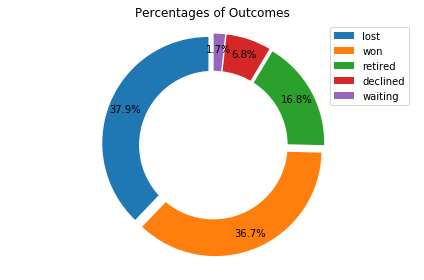

In [3]:
# drop useless variable
data.drop('id', axis = 1, inplace = True)

# get outcome variable
data['outcome'] = data['status']
data.loc[data['winner'] == data['challenger'], 'outcome'] = 'won'
data.loc[data['winner'] == data['opponent'], 'outcome'] = 'lost'

# plot outcome percentages in donut plot
def plot_donut_percentages(column, title=''):
    fig, ax = plt.subplots()
    # get labels
    labels = column.value_counts().index
    # get explode var
    explode = ()
    for i in range(0, len(labels)):
        explode += (0.05, )
    # plot donut
    ax.pie(column.value_counts(), autopct='%1.1f%%', 
           startangle=90, pctdistance=0.85, explode=explode)

    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    ax.axis('equal')
    ax.set_title(title)
    plt.legend(labels, loc="best")
    plt.tight_layout()
    plt.show()

plot_donut_percentages(data['outcome'], 'Percentages of Outcomes')

Der vorherige Graph zeigt die verschiedenen Anteile unserer Zielvariable. Insgesamt gibt es fünf mögliche Ausgänge für jedes Match. Die erste Frage die sich nun aufdrängt ist: Wofür genau interessieren wir uns? Was soll vorhergesagt werden?

Ohne direkte Aufgabe kann hier nur spekuliert werden. Ein Modell, welches jedem Status eine Wahrscheinlichkeit zuordnet, wäre durchaus machbar, scheint aber weniger interessant zu sein. Für praktische Zwecke wird es am besten sein, den Gewinner eines Matches vorherzusagen. Die zentrale Variable zur Vorhersage wird in diesem Fall also dichotom, wobei die 1 für einen Sieg des "Challengers" steht, und die 0 für eine Niederlage des Challengers. Alle Rennen, welche nicht beendet wurden und somit weder Sieger noch Velierer aufweisen müssen aus Validitäsgründen also von dem Datensatz entfernt. 

(109099, 12)


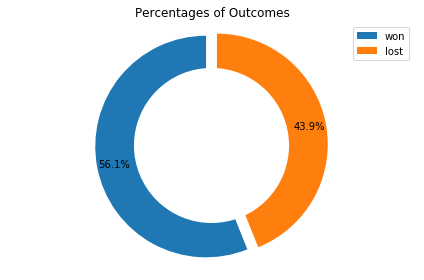

In [4]:
# drop not finished races
data = data.query("status == 'finished'")

# print new shape of dataset
print(data.shape)

# plot new outcome percentages
plot_donut_percentages(data['outcome'], 'Percentages of Outcomes')

Nach dem herausfiltern der für den vorliegenden Zweck unbrauchbaren Daten liegen noch Informationen zu 109099 individuellen Rennen vor. Insgesamt sind davon 56,1 Prozent Siege für den Challenger und der Rest Niederlagen für den Challenger.

Um die weitere Analyse und das bilden von Modellen zu ermöglichen werden nun verschiedene Umkodierungen vorgenommen.

In [5]:
# recode fuel var
data['fuel_consumption'] = pd.to_numeric(data['fuel_consumption'], errors='coerce')
data['fuel_consumption'].fillna(0, inplace=True)

# recode race driven
# split into two variables
data['race_driven'] = data['race_driven'].str.split(' ')
data['race_driven_day'] = data['race_driven'].str[0]
data['race_driven_time'] = data['race_driven'].str[1]

# get weekday
def get_weekday(date_string):
    if date_string == '0000-00-00':
        return 'NA'
    date = datetime.datetime.strptime(date_string, '%d.%m.%Y')
    return calendar.day_name[date.weekday()]

data['race_driven_weekday'] = data['race_driven_day'].apply(lambda x: get_weekday(x))

# get month
def get_month(date_string):
    if date_string == '0000-00-00':
        return 'NA'
    date = datetime.datetime.strptime(date_string, '%d.%m.%Y')
    return date.strftime('%B')

data['race_driven_month'] = data['race_driven_day'].apply(lambda x: get_month(x))

# get session
def get_session(time_string):
    if time_string == '00:00:00':
        return 'NA'
    time_list = time_string.split(':')
    time_list[0] = int(time_list[0])
    if time_list[0] > 4 and time_list[0] < 12:
        return 'Morning'
    elif time_list[0] >= 12 and time_list[0] < 17:
        return 'Afternoon'
    elif time_list[0] >= 17 and time_list[0] < 21:
        return 'Evening'
    else:
        return 'Night'

data['race_driven_session'] = data['race_driven_time'].apply(lambda x: get_session(x))

# drop old var
data.drop('race_driven', axis=1, inplace=True)

Es lagen einige Fehler in der "fuel_consumption" Variable vor. Der Ursprung dieser Fehler ist nicht ersichtlich, weshalb diese lediglich entfernt und durch den Wert 0 ersetzt werden. Innerhalb der Variable "race_driven" verstecken sich weitere möglicherweise nützliche Informationen. So wurde der jeweilige Wochentag, Monat und die Zeit des Tages in neue kategoriale Variablen geschrieben. Ob diese Informationen wirklich nützlich sind, werden spätere Analysen zeigen.

Davor werden weitere Variablen umkodiert und erstellt. Als nächstes wenden wir uns der Wettervorhersage ("forecast") zu:

In [6]:
# recode forecast variable into four separate ones
def get_sunny(forecast):
    start = forecast[19:]
    sunny = start[:start.index(';')]
    return int(sunny) / 100
  
def get_rainy(forecast):
    start = forecast[forecast.index('rainy') + 9:]
    rainy = start[:start.index(';')]
    return int(rainy) / 100

def get_thundery(forecast):
    start = forecast[forecast.index('thundery') + 12:]
    thundery = start[:start.index(';')]
    return int(thundery) / 100

def get_snowy(forecast):
    start = forecast[forecast.index('snowy') + 9:]
    snowy = start[:start.index(';')]
    return int(snowy) / 100

data['forecast_sunny'] = data['forecast'].apply(lambda x: get_sunny(x))
data['forecast_rainy'] = data['forecast'].apply(lambda x: get_rainy(x))
data['forecast_thundery'] = data['forecast'].apply(lambda x: get_thundery(x))
data['forecast_snowy'] = data['forecast'].apply(lambda x: get_snowy(x))
data.drop('forecast', axis=1, inplace=True)

Es werden so insgesamt vier neue metrische Variablen erstellt. Der Code für **get_snowy** und **get_rainy** ist zwar identisch, wird aber aus Gründen der Konsistenz dennoch in unterschiedlichen Funktionen angegeben. Wie bei den zuvor erstellten Variablen ist noch nicht klar, ob diese wirklich einen Einfluss auf den Ausgang eines Rennens haben. 

Vielversprechender scheinen aber andere Variablen zu sein: Vergangene Performance der Rennfahrer. Wie bei jedem Sport existieren auch hier unterschiedlich gute Fahrer. Aufgrund der Anordnung der Daten ist es möglich, die vorherigen Siege und Verluste der jeweiligen Rennfahrer zu berechnen. Da man nur die vergangenen Matches zur Berechnung verwendet, ist dies ein legitimes Vorgehen zur Vorhersage von zukünftigen Rennen. 

Zunächst wird die vorherige Performance für jedes Matchup berechnet. Wenn also Rennfahrer 5 schon gegen Rennfahrer 4 angetreten ist, kann diese Information zur Vorhersage des Gewinners genutzt werden. Der folgende Code berechnet dies für jede Zeile des Datensatzes:

In [7]:
## calculate previous wins
# for each matchup     
data['prev_wins'] = 0
data['prev_losses'] = 0
# for competitors overall
data['prev_wins_chall'] = 0
data['prev_losses_chall'] = 0
data['prev_wins_opp'] = 0
data['prev_losses_opp'] = 0
# for last game
data['won_last_game'] = 0

# recode vars
data['challenger'] = data['challenger'].astype(str)
data['opponent'] = data['opponent'].astype(str)

# create list of matchups with unique pairings in matchups
data['matchups'] = data['challenger'] + '-' + data['opponent']
matchups_temp = list(data['matchups'].unique())

# get all matchups
matchups = []
for match in matchups_temp:
    match = match.split('-')
    challenger = match[0]
    opponent = match[1]
    first = challenger + '-' + opponent
    second = opponent + '-' + challenger
    matchups.append(first)
    matchups.append(second)
# remove duplicates
matchups = list(set(matchups))
        
# create list of all competitors
challengers = list(data['challenger'].unique())
opponents = list(data['opponent'].unique())
all_competitors = challengers + opponents
all_competitors = list(set(all_competitors))

# save for later
column_names = data.columns
# convert data frame to list of lists for efficiency
data = data.values.tolist()

Um einzelne Zeilen des Datensatzes zu bearbeiten, ist es weit effizienter Listen zu verwenden als einen pandas-DataFrame. Der so entstandene Code ist sicherlich nicht schön, aber sehr effizient und relativ leicht verständlich.

In [8]:
# create dictionaries to store values for previous wins and losses
prev_wins = {}
for match in matchups:
    prev_wins[match] = 0
    
prev_losses = {}
for match in matchups:
    prev_losses[match] = 0

# loop through data set and calculate previous wins / losses per matchup
for j in range(0, len(data)):
    match = data[j][2] + '-' + data[j][3]
    rev_match = data[j][3] + '-' + data[j][2]
    challenger = data[j][2]
    opponent = data[j][3]
    # challenger vs opponent, won
    if data[j][2] == challenger and data[j][3] == opponent and data[j][9] == 'won':
        data[j][19] = prev_wins[match]
        prev_wins[match] += 1
        # prev losses
        data[j][20] = prev_losses[match]
        prev_losses[rev_match] += 1
    # challenger vs opponent, lost
    elif data[j][2] == challenger and data[j][3] == opponent and data[j][9] == 'lost':
        data[j][19] = prev_wins[match]
        prev_wins[rev_match] += 1
        # prev losses
        data[j][20] = prev_losses[match]
        prev_losses[match] += 1
    # opponent vs challenger, won
    elif data[j][2] == opponent and data[j][3] == challenger and data[j][9] == 'won':
        data[j][19] = prev_wins[rev_match]
        prev_wins[rev_match] += 1
        # prev losses
        data[j][20] = prev_losses[rev_match]
        prev_losses[match] += 1
    # opponent vs challenger, lost
    elif data[j][2] == opponent and data[j][3] == challenger and data[j][9] == 'lost':
        data[j][19] = prev_wins[rev_match]
        prev_wins[match] += 1
        # prev losses
        data[j][20] = prev_losses[rev_match]
        prev_losses[rev_match] += 1
    # challenger vs opponent other
    elif data[j][2] == challenger and data[j][3] == opponent:
        data[j][19] = prev_wins[match]
        # prev losses
        data[j][20] = prev_losses[match]
    # opponent vs challenger other
    elif data[j][2] == opponent and data[j][3] == challenger:
        data[j][19] = prev_wins[rev_match]
        # prev losses
        data[j][20] = prev_losses[rev_match]

Mit einem ähnlichen Verfahren werden nun auch die Performances für Challenger und Opponent insgesamt berechnet.

In [9]:
# for challengers
prev_wins = {}
for comp in all_competitors:
    prev_wins[comp] = 0
    
prev_losses = {}
for comp in all_competitors:
    prev_losses[comp] = 0

for j in range(0, len(data)):
    chall = data[j][2]
    opp = data[j][3]
    # challenger vs opponent, win
    if data[j][2] == chall and data[j][9] == 'won':
        data[j][21] = prev_wins[chall]
        data[j][22] = prev_losses[chall]
        prev_wins[chall] += 1
        prev_losses[opp] += 1
    # challenger vs opponent, lost
    elif data[j][2] == chall and data[j][9] == 'lost':
        data[j][21] = prev_wins[chall]
        data[j][22] = prev_losses[chall]
        prev_losses[chall] += 1
        prev_wins[opp] += 1
    # opponent vs challenger, win
    elif data[j][3] == chall and data[j][9] == 'won':
        data[j][21] = prev_wins[chall]
        data[j][22] = prev_losses[chall]
        prev_losses[chall] += 1
        prev_wins[opp] += 1
    # opponent vs challenger, lost
    elif data[j][3] == chall and data[j][9] == 'lost':
        data[j][21] = prev_wins[chall]
        data[j][22] = prev_losses[chall]
        prev_wins[chall] += 1
        prev_losses[opp] += 1
    # other
    elif data[j][2] == chall:
        data[j][21] = prev_wins[chall]
        data[j][22] = prev_losses[chall]
    elif data[j][3] == chall:
        data[j][21] = prev_wins[chall]
        data[j][22] = prev_losses[chall]

In [10]:
# for opponents
prev_wins = {}
for comp in all_competitors:
    prev_wins[comp] = 0
    
prev_losses = {}
for comp in all_competitors:
    prev_losses[comp] = 0

for j in range(0, len(data)):
    chall = data[j][3]
    opp = data[j][2]
    # challenger vs opponent, win
    if data[j][2] == chall and data[j][9] == 'won':
        data[j][23] = prev_wins[chall]
        data[j][24] = prev_losses[chall]
        prev_wins[chall] += 1
        prev_losses[opp] += 1
    # challenger vs opponent, lost
    elif data[j][2] == chall and data[j][9] == 'lost':
        data[j][23] = prev_wins[chall]
        data[j][24] = prev_losses[chall]
        prev_losses[chall] += 1
        prev_wins[opp] += 1
    # opponent vs challenger, win
    elif data[j][3] == chall and data[j][9] == 'won':
        data[j][23] = prev_wins[chall]
        data[j][24] = prev_losses[chall]
        prev_losses[chall] += 1
        prev_wins[opp] += 1
    # opponent vs challenger, lost
    elif data[j][3] == chall and data[j][9] == 'lost':
        data[j][23] = prev_wins[chall]
        data[j][24] = prev_losses[chall]
        prev_wins[chall] += 1
        prev_losses[opp] += 1
    # other
    elif data[j][2] == chall:
        data[j][23] = prev_wins[chall]
        data[j][24] = prev_losses[chall]
    elif data[j][3] == chall:
        data[j][23] = prev_wins[chall]
        data[j][24] = prev_losses[chall]

Und noch einmal wird auf ähnliche Weise eine weitere Variable generiert, welche anzeigt, ob der Challenger sein letztes Match gegen diesen speziellen Opponent gewonnen hat. Ein vorheriger Sieg kann einen psychologischen Vorteil geben und erhöht deshalb möglicherweise die Chancen auf einen Sieg.

In [11]:
# if last game of matchup won 1, else 0
prev_wins = {}
for match in matchups:
    prev_wins[match] = 0
    
for j in range(0, len(data)):
    match = data[j][2] + '-' + data[j][3]
    rev_match = data[j][3] + '-' + data[j][2]
    challenger = data[j][2]
    opponent = data[j][3]
    # challenger vs opponent, won
    if data[j][2] == challenger and data[j][3] == opponent and data[j][9] == 'won':
        data[j][25] = prev_wins[match]
        prev_wins[match] = 1
        prev_wins[rev_match] = 0
    # challenger vs opponent, lost
    elif data[j][2] == challenger and data[j][3] == opponent and data[j][9] == 'lost':
        data[j][25] = prev_wins[match]
        prev_wins[rev_match] = 1
        prev_wins[match] = 0
    # opponent vs challenger, won
    elif data[j][2] == opponent and data[j][3] == challenger and data[j][9] == 'won':
        data[j][25] = prev_wins[rev_match]
        prev_wins[rev_match] = 1
        prev_wins[match] = 0
    # opponent vs challenger, lost
    elif data[j][2] == opponent and data[j][3] == challenger and data[j][9] == 'lost':
        data[j][25] = prev_wins[rev_match]
        prev_wins[match] = 1
        prev_wins[rev_match] = 0
    # challenger vs opponent other
    elif data[j][2] == challenger and data[j][3] == opponent:
        data[j][25] = prev_wins[match]
    # opponent vs challenger other
    elif data[j][2] == opponent and data[j][3] == challenger:
        data[j][25] = prev_wins[rev_match]

In [12]:
# convert back to pandas data frame
data = pd.DataFrame(data)

# reassign column names
data.columns = column_names

Nach der Berechnung der neuen Variablen wird der Datensatz zur weiteren Analyse wieder zu einem pandas-DataFrame umgewandelt. 

Mit den so erstellten Variablen lassen sich nun weitere nützliche Variablen erstellen:

In [13]:
# create some new variables
data['prev_matches'] = data['prev_wins'] + data['prev_losses']
data['prev_win_perc'] = data['prev_wins'] / data['prev_matches']
data['prev_win_perc'].fillna(0.5, inplace=True)
data['prev_win_match_interact'] = data['prev_win_perc'] * data['prev_matches']

data['prev_matches_chall'] = data['prev_wins_chall'] + data['prev_losses_chall']
data['prev_win_perc_chall'] = data['prev_wins_chall'] / data['prev_matches_chall']
data['prev_win_perc_chall'].fillna(0.5, inplace=True)
data['prev_win_match_interact_chall'] = data['prev_win_perc_chall'] * data['prev_matches_chall']

data['prev_matches_opp'] = data['prev_wins_opp'] + data['prev_losses_opp']
data['prev_win_perc_opp'] = data['prev_wins_opp'] / data['prev_matches_opp']
data['prev_win_perc_opp'].fillna(0.5, inplace=True)
data['prev_win_match_interact_opp'] = data['prev_win_perc_opp'] * data['prev_matches_opp']

# calculate differences for greater predictive value
data['prev_win_perc_diff'] = data['prev_win_perc_chall'] - data['prev_win_perc_opp']
data['prev_matches_diff'] = data['prev_matches_chall'] - data['prev_matches_opp']
data['prev_win_match_interact_diff'] = data['prev_win_match_interact_chall'] - data['prev_win_match_interact_opp']

# drop redundant vars
dropping = ['prev_wins_chall', 'prev_losses_chall', 'prev_wins', 'prev_losses', 
            'prev_wins_opp', 'prev_losses_opp']
for col in dropping:
    data.drop(col, axis=1, inplace=True)

Statt direkt die absoluten Siege und Niederlagen zu verwenden, werden der Anteil an Siegen und die Gesamtzahl von Matches berechnet. Bei den Statistiken für Challenger und Opponent allein scheint eine Bildung der Differenzen zwischen den Variablen nützlich zu sein. Des Weiteren werden einige Interaktionsvariablen berechnet, welche den Anteil der Siege mit der Anzahl der Matches gewichtet. Wenn zum Beispiel ein Spieler nur ein vorheriges Match hatte und dies gewonnen hat, hätte er einen Gewinnanteil von 100%. Durch die Gewichtung wird deutlich gemacht, wie wertvoll dieser Wert wirklich ist.

Wir kommen den ersten Vorhersagemodellen bereits näher! Ein wenig Datenaufbereitung ist aber noch immer nötig.

In [14]:
# get target variable
data['target_win'] = 0
data.loc[data['outcome'] == 'won', 'target_win'] = 1

# drop variables useless for prediction
dropping = ['race_created', 'challenger', 'opponent', 'winner', 'status',
            'outcome', 'race_driven_day', 'race_driven_time', 'matchups',
            'track_id']
for col in dropping:
    data.drop(col, axis=1, inplace=True)

Variablen, die aus logischen Gründen nicht im Modell verwendet werden können, wurden gelöscht. Außerdem wurde die Zielvariable ("target_win") erstellt. Nun müssen kategoriale Variablen noch zu einzelnen dichotomen Variablen umgewandelt werden. Der folgende Code erledigt dies:

In [15]:
# make dummies
cols = ['weather', 'race_driven_weekday', 'race_driven_month',
        'race_driven_session']
data = pd.get_dummies(data, prefix=cols, columns=cols)

Damit sind die Daten bereit, um in verschiedene Sets eingeteilt zu werden. Um die Validität eines Modells zu überprüfen, ist es wichtig, es an Daten zu testen, die der Algorithmus noch nicht gesehen hat. Da man aber auch verschiedene Parameter testen will ohne sein Modell zu stark auf die Testdaten abzurichten, braucht man in der Regel drei Datensätze: *Trainingsdaten*, *Validations-Daten* und *Testdaten*.

Normalerweise werden diese durch einfache Zufallsstichproben (oder manchmal auch geschichtete Zufallsstichproben) entnommen, da nur so mathematisch gesehen Repräsentativität gegeben ist. Für den vorliegenden Fall ist dies aber nicht das beste Vorgehen. Da die Daten teilweise aufeinander aufbauen und es das Ziel ist die Zukunft vorherzusagen, sollte genau dies auch in unserem Modell geschehen. Zur Vorhersage der Testdaten (und Validations-Daten) werden hier also ausschließlich Daten aus vorherigen Rennen benutzt.

In [16]:
# reallocate 20% of the data for testing
train_full, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)
train, val = train_test_split(train_full, test_size=0.3, random_state=42, shuffle=False)

# split further for training and analysis
# train data
train_y = train['target_win']
train_x = train.drop('target_win', axis=1)

# validation data
val_y = val['target_win']
val_x = val.drop('target_win', axis=1)

# test data
test_y = test['target_win']
test_x = test.drop('target_win', axis=1)

# full test data (will only be used to retrain the model after tuning it)
train_full_y = train_full['target_win']
train_full_x = train_full.drop('target_win', axis=1)

Nach dieser Einteilung kann nun mit der Exploration der Daten begonnen werden. Nur so kann gewährleistet werden, dass keine Informationen aus den Testdaten bereits in der Modellbildung verwendet werden.

Zuerst betrachten wir die Korrelationen von allen Variablen mit der Zielvariable. Da die Zielvariable dichotom ist und viele der anderen Variablen ebenfalls, kann keine Pearson Korrelation verwendet werden. Stattdessen wird die Point-Biserial Korrelation zum Einsatz gebracht. Diese hat ebenfalls einen Wertebereich von -1 bis 1, wobei die Werte auf gleiche Weise zu interpretieren sind wie bei einer Pearson Korrelation.

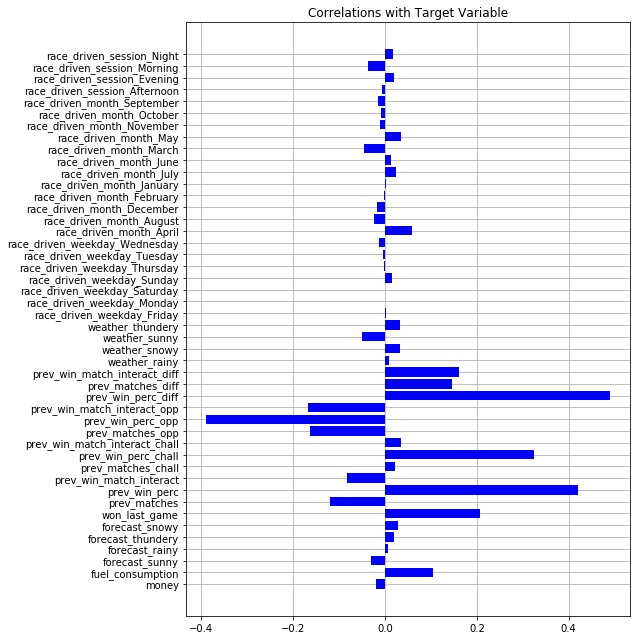

In [17]:
# plot point-biserial correlations with target variable
def plot_correlations(data, labels):
    correlations = []
    for col in data.columns:
        if col != 'target_win':
            cor = sc.stats.pointbiserialr(data[col], labels)
            correlations.append((col, cor[0]))
    
    labels, ys = zip(*correlations)
    xs = np.arange(len(labels)) 

    plt.figure(figsize=(9, 9))
    plt.title('Correlations with Target Variable')
    plt.grid(zorder=0)
    plt.barh(xs, ys, 0.8, align='center', color='b', zorder=3)
    plt.yticks(xs, labels)
    plt.tight_layout()
    
plot_correlations(train_x, train_y)

Wie vermutet korrelieren die verschiedenen Variablen zur vorherigen Leistung der Rennfahrer am stärksten mit der Zielvariable. Mit Korrelationen von bis zu 0.4 und -0.4 handelt es sich um mittelstarke Zusammenhänge. Variablen, die mit dem Zeitpunkt des Rennens zu tun haben, korrelieren nur wenig bis gar nicht mit der Zielvariablen.

Wichtig ist hier anzumerken, dass hier lediglich lineare Beziehungen gemessen werden. Es wären auch andere Zusammenhänge denkbar, weshalb nur auf Grundlage dieser Korrelationen nicht direkt Variablen entfernt werden sollten.

Eine Möglichkeit nicht-lineare Zusammenhänge zu betrachten sind: *Robust Locally Weighted Regression*, besser bekannt unter dem Namen *Lowess-* oder *Loess*-Regressionen. Der Voteil an dieser Art von Regression gegenüber linearen oder logistichen Regressionen ist, dass jede Art von Zusammenhang erkennbar gemacht werden, da es sich um ein nicht-parametrisches Verfahren handelt. Betrachten wir diese für einige ausgewählte Variablen:

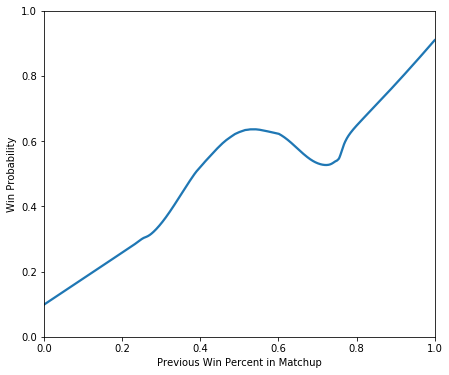

In [18]:
# plot lowess regression line
def plot_lowess(variable, name='', x_range=(0, 1)):
    f, ax = plt.subplots()
    ax.set(xlim=x_range, ylim=(0, 1))
    f.set_size_inches(7, 6)
    fig = sns.regplot(variable, train_y, lowess=True, scatter=False)
    plt.ylabel('Win Probability')
    plt.xlabel(name)

plot_lowess(train_x['prev_win_perc'], name='Previous Win Percent in Matchup')

Die eigentlich dichotome Zielvariable wird hier als metrische Variable verwendet. Dies ist völlig legitim, wenn man die Werte als Wahrscheinlichkeiten des Auftretens der Zielvariable interpretiert. In diesem Falle ist es also die Wahrscheinlichkeit, dass der Challenger das Rennen gewinnt. Eine klare lineare Beziehung ist erkennbar. Je größer die vorherige Siegwahrscheinlichkeit des Challengers, desto höher sind seine Gewinnchancen. Erkennbar ist aber ebenso, dass es kein perfekt linearer Zusammenhang ist. Die Steigung um den Wert 0.5 hängt wahrscheinlich mit der Imputation von fehlenden Werten als 0.5 zusammen.

Die einfache Imputation von Zahlen ist grundsätzlich nicht trivial. Ohne verschiedene meist ungerechtfertigte Annahmen kann selbst die Imputation des Mittelwertes oder des Medians einer Verteilung zu verzerrten Ergebnissen führen. Für den vorliegenden Fall scheint die Imputation des Wertes 0,5 aber dennoch am sinnvollsten zu sein.

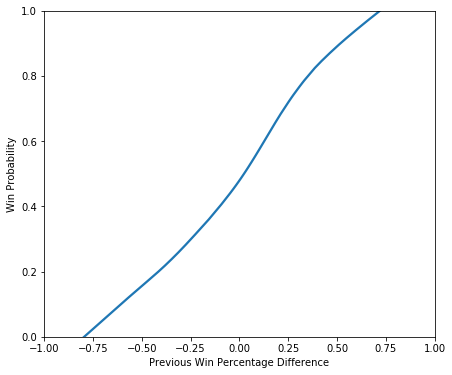

In [19]:
plot_lowess(train_x['prev_win_perc_diff'], name='Previous Win Percentage Difference'
            , x_range=(-1, 1))

Auch hier ist ein ähnlicher Effekt erkennbar. Je größer die Differenz ist, desto höher ist die Wahrscheinlichkeit, dass der Challenger das Rennen gewinnt. Bei einer Differenz von 0, wenn also der Anteil der vorherigen Siege in beiden Rennfahrern gleich ist, liegt die Siegwahrscheinlichkeit bei 0,5 Prozent, was ebenfalls intutitiv Sinn ergibt.

Wie viel Erklärungskraft diese Variablen zur Vorhersage in einem Modell haben, lässt sich allerdings nur durch ausprobieren herausfinden. Für binäre Klassifikationsmodelle wird meist ein logistisches Regressionsmodell als "Baseline" verwendet. Von dieser Baseline aus hat man einen ersten Eindruck, welche Erklärungskraft die Daten haben. Bilden wir also ein solches Modell:

In [20]:
# train model
log = LogisticRegression(random_state=42)
log.fit(train_x, train_y)

# function to evaluate predictions
def pred_stats(true, pred, rounding=4):
    acc = accuracy_score(true, pred)
    n = len(true)
    upper = acc + 1.96 * math.sqrt((acc * (1 - acc)) / n)
    lower = acc - 1.96 * math.sqrt((acc * (1 - acc)) / n)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f_stat = f1_score(true, pred)
    print('Accuracy:     ', round(acc, rounding))
    print('95% CI Upper: ', round(upper, rounding))
    print('95% CI Lower: ', round(lower, rounding))
    print('Precision:    ', round(precision, rounding))
    print('Recall:       ', round(recall, rounding))
    print('F-Score:      ', round(f_stat, rounding))

# make and evaluate predictions
predicted = log.predict(val_x)
pred_stats(val_y, predicted)

Accuracy:      0.7442
95% CI Upper:  0.7495
95% CI Lower:  0.7389
Precision:     0.7478
Recall:        0.8029
F-Score:       0.7744


*Accuracy* beschreibt den Anteil der vom Modell richtig vorhergesagten Labels. In diesem Falle heißt ein Wert von 0,7431 also das 74,31 Prozent der Ausgänge der Rennen richtig durch das Modell vorhergesagt wurden. Dieser Wert muss immer in Relation zu den vorliegenden Daten bewertet werden. Falls die zu vorhersagenden Kategorien nicht exakt den gelichen Anteil haben, könnte das Modell durch die dauerhafte Vorhersage der häufigsten Kategorie einen hohen Wert erreichen, obwohl das Modell in der Praxis wertlos ist. Da hier die Anteile von Niederlagen und Siegen fast gleich ist, ist eine Accuracy von 0,7431 für ein derart simples Modell durchaus akzeptabel. Wir sollten in der Lage sein, einen um einiges besseren Score zu erhalten, indem wir komplexere Modelle verwenden.

Versuchen wir es mit einem Random Forest, zunächst wieder ohne die voreingestellten Parameter zu verändern.

In [21]:
# train model
forest = RandomForestClassifier(random_state=42)
forest = forest.fit(train_x, train_y)

# predict and evaluate
predicted = forest.predict(val_x)
pred_stats(val_y, predicted)

Accuracy:      0.7568
95% CI Upper:  0.762
95% CI Lower:  0.7516
Precision:     0.7908
Recall:        0.7549
F-Score:       0.7724


Mit einer Accuracy von 0,7568 ist dieses Modell etwas besser als die Baseline der logistischen Regression! Dieser Unterschied ist bei einer derat großen Fallzahl signifikant, was man an den Grenzen des ausgegebenen Konfidenzintervalls erkennen kann. Das bedeutet, dass der Unterschied wahrscheinlich nicht durch puren Zufall zu erklären ist. 

Einer von vielen Vorteilen von Random Forests ist, dass man sich ohne viel Aufwand die Wichtigkeit von verschiedenen Variablen des Modells angucken kann. So können Variablen, welche keinen oder wenig Einfluss haben entfernt werden. Je simpler das Modell, desto größer ist die Wahrscheinlichkeit, dass es an neuen Daten bessere Ergebnisse liefert.

Der folgende Graph zeigt dies für unser erstes einfaches Modell.

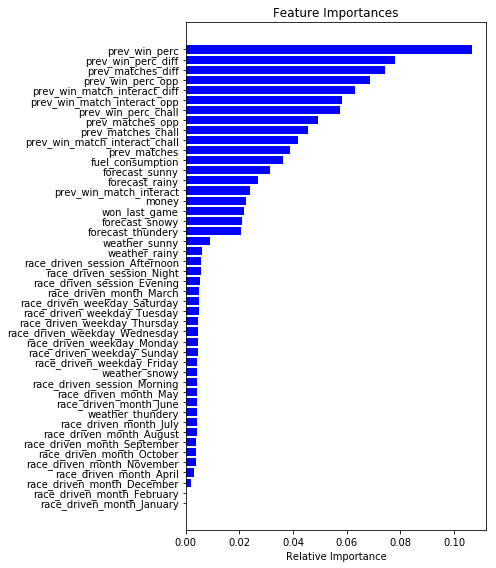

In [22]:
# feature importance plot
def plot_feature_importances(data, forest):
    features = data.columns
    importances = forest.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize = (7, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    
plot_feature_importances(train_x, forest)

Die für die Vorhersage wichtigsten Variablen sind die vorherigen Ausgänge von Rennen im selben Matchup, sowie die Differenz der generellen Sieganteile der beiden Rennfahrer. Für die verschiedenen Variablen zur vorherigen Performance kann der Zusammenhang zur Zielvariable klar theoretisch begründet werden. Manche Sportler sind besser als andere, haben anderes Equipment (hier eventuell teurere Fahrzeuge) oder bessere Techniken. 

Die verschiedenen Dummies für unterschiedliche Monate, Wochentage und Tageszeiten scheinen relativ unwichtig zu sein und sollten entfernt werden.

In [23]:
# drop some variables with no predictive value
dropping = ['race_driven_month_January', 'race_driven_month_February',
            'race_driven_month_December', 'race_driven_month_October',
            'race_driven_month_August', 'race_driven_weekday_Wednesday',
            'race_driven_month_November', 'race_driven_month_June',
            'race_driven_month_July', 'race_driven_month_March',
            'race_driven_weekday_Monday', 'race_driven_month_September',
            'race_driven_weekday_Friday', 'race_driven_month_May', 
            'race_driven_weekday_Saturday', 'race_driven_weekday_Tuesday',
            'race_driven_month_April', 'race_driven_weekday_Thursday',
            'race_driven_weekday_Sunday', 'race_driven_session_Morning',
            'race_driven_session_Evening', 'race_driven_session_Night',
            'race_driven_session_Afternoon', 'weather_thundery',
            'weather_snowy', 'weather_rainy']
for col in dropping:
    train_x.drop(col, axis=1, inplace=True)
    val_x.drop(col, axis=1, inplace=True)
    test_x.drop(col, axis=1, inplace=True)
    train_full_x.drop(col, axis=1, inplace=True)

Eine weitere Möglichkeit, um das Modell zu verbessern, ist das Entfernen von Variablen, welche sehr stark untereinander korreliert sind. Um dies zu überprüfen, wird folgende Korrelations-Matrix-Heatmap erstellt. Dabei wird wenn nötig die Point-Biserial Korrelation verwendet, ansonsten die Pearson Korrelation.

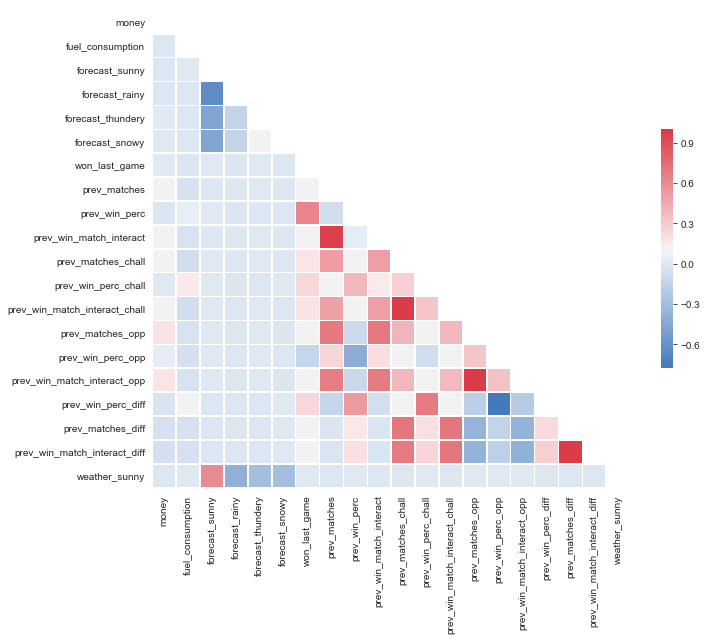

In [24]:
# calculate correlations
corr = []
for col in train_x.columns:
    corr_line = []
    for line in train_x.columns:
        # if at least one var is dichotomous, biserial correlation
        if len(train_x[col].unique()) == 2 or len(train_x[line].unique()) == 2:
            cor = sc.stats.pointbiserialr(train_x[col], train_x[line])
            corr_line.append(cor[0])
        # else pearson correlation
        else:
            cor = sc.stats.pearsonr(train_x[col], train_x[line])
            corr_line.append(cor[0])
    corr.append(corr_line)

# get labels back
corr = pd.DataFrame(corr)
corr.columns = train_x.columns
corr.index = train_x.columns

# plot correlation heatmap
def plot_corr_heatmap(data, dropDuplicates=True):
    if dropDuplicates:    
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    sns.set_style(style = 'white')
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    if dropDuplicates:
        sns.heatmap(data, mask=mask, cmap=cmap, square=True, linewidth=0.5, 
                    cbar_kws={"shrink": 0.5}, ax=ax)
    else:
        sns.heatmap(data, cmap=cmap, square=True, linewidth=0.5, 
                    cbar_kws={"shrink": 0.5}, ax=ax)
    plt.tight_layout()
    
plot_corr_heatmap(corr)

Dieser Plot zeigt uns, dass einige Variablen sehr stark miteinander zusammenhängen. Dies kann zu einer schlechteren Performance von Modellen führen. Aus diesem Grund werden diese Variablen ebenfalls entfernt.

In [25]:
# drop highly correlated variables
dropping = ['prev_win_match_interact_chall', 'prev_matches_opp',
            'prev_matches_diff', 'prev_win_perc_chall',
            'prev_matches']
for col in dropping:
    train_x.drop(col, axis=1, inplace=True)
    val_x.drop(col, axis=1, inplace=True)
    test_x.drop(col, axis=1, inplace=True)
    train_full_x.drop(col, axis=1, inplace=True)

Zusätzlich müssen noch die Parameter des Modells angepasst werden. Anstatt ziellos herumzuprobieren, wurde dafür die Funktion GridSearch, welche vom sklearn Modul bereitgestellt wird, verwendet. Dieser bildet aus einer beliebigen Zahl von verschiedenen Parametern alle möglichen verschiedenen Modelle und errechnet die jeweiligen Scores an den Validierungs-Daten. Da dieses Vorgehen sehr zeitaufwändig ist, wird der Code dafür hier nicht angegeben. Das folgende Modell ist das Ergebnis dieses Vorgehens:

In [26]:
forest = RandomForestClassifier(n_estimators=170, min_samples_split=100,
                                min_samples_leaf=5, random_state=42)
forest = forest.fit(train_x, train_y)

predicted = forest.predict(val_x)
pred_stats(val_y, predicted)

Accuracy:      0.8049
95% CI Upper:  0.8097
95% CI Lower:  0.8001
Precision:     0.8271
Recall:        0.8131
F-Score:       0.82


Dies sieht schon sehr viel besser aus als das erste Modell! Alle relevanten Scores liegen über 0,8. Mit einer Accuracy von knapp 0,8 kann das Modell also ungefähr 80 % der Sieger innerhalb der Validations-Daten vorhersagen. Die F-Statistik ist ebenfalls relativ hoch und entspricht ungefähr den Werten der Präzision und des Recalls. Das bedeutet, dass wahrscheinlich ungefähr gleich viele Falschen-Positive (Modell sagt Sieg voraus, tritt aber nicht ein) und Falschen-Negative (Modell sagt Niederlage voraus, der Challenger gewinnt) existieren.

Um dies genauer zu beleuchten betrachten wir die *Confusion-Matrix*.

In [27]:
confusion_matrix(val_y, predicted)

array([[ 9435,  2434],
       [ 2675, 11640]], dtype=int64)

Die Vermutung hat sich bestätigt. Allgemein scheint das Modell also gute Vorhersagen zu liefern, auch wenn "gut" immer vom Verwendungszweck abhängig ist. Es ist definitiv weit besser als ein einfaches Raten anhand der bekannten Anteilswerte.

Da allerdings sehr viele Modelle an den Validations-Daten getestet wurden, ist es durchaus möglich, dass dieses Modell dennoch "overfitted" ist und neue noch nie zuvor gesehene Daten nicht gut vorhersagen kann. Aus diesem Grund muss es als finaler Test auch noch mit den Test-Daten validiert werden. Weil mehr Daten generell bessere Modelle produzieren, wird das Modell zuvor an den gesamten Trainings-Daten neu trainiert.

In [28]:
# retrain best model on full training data
forest = RandomForestClassifier(n_estimators=170, min_samples_split=100,
                                min_samples_leaf=5, random_state=42)
forest = forest.fit(train_full_x, train_full_y)

# make final predicitons on test set
predicted = forest.predict(test_x)
pred_stats(test_y, predicted)

Accuracy:      0.81
95% CI Upper:  0.8152
95% CI Lower:  0.8048
Precision:     0.8264
Recall:        0.8196
F-Score:       0.823


Diese Werte sind etwas besser als die Vorhersagen der Validations-Daten. Da mehr Trainings-Daten zur Verfügung standen, war eine kleine Verbesserung zu erwarten. Es scheint kein overfitting vorzuliegen. Insgesamt ein akzeptables Ergebnis!

Betrachten wir abschließend noch einmal die verschiedenen relativen Wichtigkeiten der einzelnen Variablen.

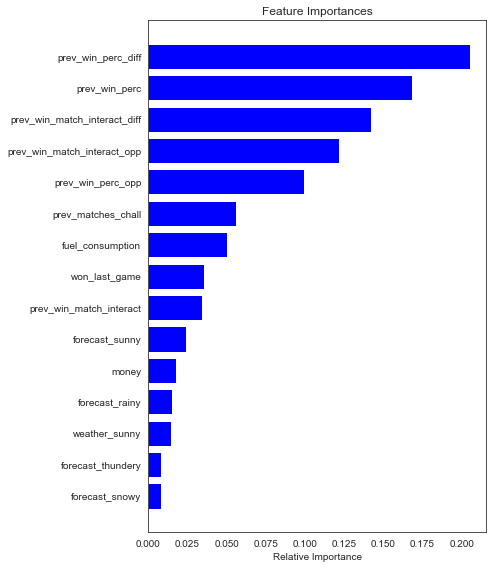

In [29]:
plot_feature_importances(train_full_x, forest)

Insgesamt entspricht dies dem Bild, welches sich uns schon beim einfachsten Random-Forest Modell gezeigt hat. Mit Abstand am wichtigsten zur Vorhersage des Gewinners sind Daten zur vorherigen Performance.

Die zu Beginn gestellte Frage, ob nur mit den Daten zu vorherigen Matches die Ausgänge von zukünftigen Rennen vorhergesagt werden können, kann so also mit einem bedingten "Ja" beantwortet werden. Eine perfekte Vorhersage ist nicht möglich, dies wäre aber auch verwunderlich gewesen. Mit knapp 81% an richtigen Vorhersagen ist das Modell aber durchaus besser als pures raten.